In [1]:
import numpy as np
import pandas as pd
from SWMM import SWMM_ENV as SWMM_ENV
import datetime
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import os
import yaml

import shutil
import datetime

import pyswmm
from swmm_api.input_file import read_inp_file
from pyswmm import Simulation,Links,Nodes,RainGages,SystemStats
from swmm_api.input_file.sections.others import TimeseriesData
from swmm_api.input_file.sections import Control
from swmm_api.input_file.section_labels import TIMESERIES, CONTROLS
from swmm_api import read_rpt_file, SwmmReport

import data_clustering

def delete_folder_contents(folder_path):
    try:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                os.remove(file_path)
            for dir in dirs:
                dir_path = os.path.join(root, dir)
                shutil.rmtree(dir_path)
        print(f"文件夹 {folder_path} 内的所有文件和子文件夹已成功删除。")
    except FileNotFoundError:
        print(f"错误: 文件夹 {folder_path} 未找到。")
    except PermissionError:
        print(f"错误: 没有权限删除文件夹 {folder_path} 内的文件或子文件夹。")
    except Exception as e:
        print(f"发生未知错误: {e}")

# 根据分区选出所有node和link的名字，打包为字典
# 一共有8个分区，包括6个区域、干管、调蓄

In [2]:
split = {
    '1':{
        'subs':['sub69','sub70'],
        'links':[],
        'nodes':['YS02001605','YS02001596','YS02001586']
    },
    '2':{
        'subs':['sub63','sub64','sub65','sub66'],
        'links':[],
        'nodes':['YS02001607','YS02001619','YS02001629',
                 'YS02164001','YS02001649','YS02001661']
    },
    '3':{
        'subs':['sub60','sub61','sub62'],
        'links':[],
        'nodes':['YS02001779','YS02001765','YS02001757','YS02001748']
    },
    '4':{
        'subs':['sub67','sub68','sub71','sub72'],
        'links':[],
        'nodes':['YS02001882','YS02001895','YS02001907',
                 'YS02001929','YS02001918']
    },
    '5':{
        'subs':['sub5','sub12','sub14','sub15','sub16','sub22','sub23'],
        'links':[],
        'nodes':['HS02004901','HS02004785','HS02004480',
                 'YSB1154','YSB1174']
    },
    '6':{
        'subs':['sub0','sub1','sub2','sub3','sub4',
                'sub7','sub8','sub9','sub10'],
        'links':[],
        'nodes':['HS02004881','HS02004856','HS02004837','HS02004802']
    },
    'main':{
        'links':[],
        'nodes':['WS02006251','WS02006243','WS02006235','WS02006229',
                 'WS02006112','WS02004402']
    },
    'pump':{
        'links':[],
        'nodes':['CC-storage','JK-storage']
    }
}


state_nodes = []
for k in split.keys():
    state_nodes += split[k]['nodes']

inp = read_inp_file('./SWMM/chaohu_DN.inp')
state_nodesdepth = {}
for k in state_nodes:
    if 'storage' not in k:
        state_nodesdepth[k]=inp.JUNCTIONS[k].depth_max
    else:
        state_nodesdepth[k]=inp.STORAGE[k].depth_max

# 模拟获取结果数据作为历史数据 已经模拟完成，结果保存在results文件夹中，不用再运行

## 装配多场降雨

In [3]:
def get_results(sim,t,data):
    nodes = Nodes(sim)
    links = Links(sim)
    rgs = RainGages(sim)
    sys = SystemStats(sim)

    for k1 in state_nodes:#nodenames:
        data[k1].append(nodes[k1].depth)

# env参数
st = 'SWMM\\chaohu'
env_params = {
    'orf':st,
    'orf_save':'chaohu_RTC',# opt中使用不同的inp计算，上两个参数没有用到
    'parm':'states_yaml\\chaohu',
    'advance_seconds':300,
    'kf':1,
    'kc':1,
    'reward_type':'3',
}
config = yaml.load(open(env_params['parm']+".yaml"), yaml.FullLoader)
action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:].tolist()

# 1000场 6组合的降雨
raindata = np.load('./rainfall/chaohu_rainfall/spdiff_raindata.npy',allow_pickle=True).tolist()

## 查看降雨

In [4]:
# 降雨保存在list，每个对象是一个字典，字典key为0-5，每个key对应单场降雨是之前的单场
print(raindata[0].keys())

dict_keys([0, 1, 2, 3, 4, 5])


## 模拟过程，现在版本的6场降雨如何加入，以及如何模拟见这个部分

In [ ]:
class BC_sim:
    def __init__(self,rainid,rainname,env_params,config):
        self.rainid,self.rainname = rainid, rainname
        self.action_table = pd.read_csv(os.getcwd()+'\\SWMM\\action_table.csv').values[:,1:]
        self.env_params = env_params
        self.config = config
    
    def reset(self,raindata):
        # 初始化
        inp = read_inp_file('./SWMM/chaohu_multirain.inp')
        # 加入降雨，多场降雨
        # 必须用新版的swmm，在新版的inp里面的降雨已经和6场降雨对应
        for i in range(len(list(raindata[self.rainid].keys()))):
            inp[TIMESERIES]['rainfall'+str(i)]=TimeseriesData('rainfall'+str(i),raindata[self.rainid][i])
        # 用于最终模拟的inp
        inp.write_file('./SWMM/_temopt_original/BC/chaohu_multirain_' + self.rainname + str(self.rainid)+'.inp')

    def opt_mp(self):
        # 读取模型开始优化调整action
        # 读取模拟,获取评分结果
        data={}
        for k in state_nodes:
            data[k] = []

        sim_tem = Simulation('./SWMM/_temopt_original/BC/chaohu_multirain_'+self.rainname+str(self.rainid)+'.inp')
        sim_tem.start()
        for step in range(95):
            sim_tem._model.swmm_stride(self.env_params['advance_seconds'])
            get_results(sim_tem,step,data)
        sim_tem._model.swmm_end()
        sim_tem._model.swmm_close()

        return data

In [26]:
for i in range(len(raindata)):
    optsys = BC_sim(i,'design',env_params,config)
    optsys.reset(raindata)
    results = optsys.opt_mp()
    np.save('./results/BC_real_results_designrain'+str(i),results)

# 获取模拟数据，并通过各个分区的水位计算state

In [5]:
# get results of all file
folder_path = os.getcwd()
file_list = []
for item in os.listdir(folder_path+'/results'):
    file_list.append(item)

waterlevel = {}
for f in file_list:
    waterlevel[f]=np.load(folder_path+'/results/'+f,allow_pickle=True).tolist()

## 水位转为6个区域state的方法

In [ ]:
# 根据分区计算冗余度，并以冗余度作为state进行分类和DRL控制，这个函数会用于后续DRL训练测试

def wl2state(wl,state_nodesdepth,split):
    """
    将实时水位结果转化为基于冗余度的state
    params:这三个变量见上部分
        wl: real-time water level of selected nodes
        state_nodesdepth: the max depth of all nodes
        split: a dict containt the info of splitted UDS

    return:
        list: state
    """
    state = []
    for k in split.keys():
        nodes = split[k]['nodes']
        # get water level of all nodes in one split
        tem = 0
        for n in nodes:
            tem += wl[n]/state_nodesdepth[n]
        # get the average capacity of each nodes
        state.append(tem/len(nodes))

    return state

In [8]:
# Get all the state data based on the above simulation
state_data = []
for s in waterlevel.keys():
    # for each simulation case
    case = waterlevel[s]
    # for all the time steps
    for t in range(95):
        wl = {}
        #根据分区以及分区对应的node计算state
        for k in case.keys():
            wl[k]=case[k][t]
        state = wl2state(wl,state_nodesdepth,split)
        # store every state data
        state_data.append(state)

state_data = np.array(state_data)
print(state_data.shape)

(95000, 8)


# 根据这个“基于知识”的分类，初步确定类别多少，以及每个类别的实际含义

<BarContainer object of 256 artists>

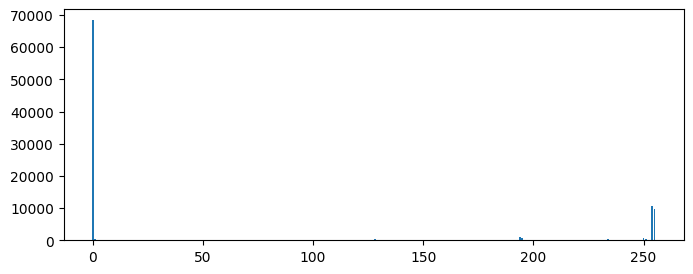

In [13]:
# 8个state，每个state都有两个状态，一共应该有2^8=256种，每个分类不都包含有数据，因此实际类别远小于此
#先给出类别判断标准，以0.7作为界限区分（肯定是不均衡的）

category = {}
for a1 in ['l','f']:
    for a2 in ['l','f']:
        for a3 in ['l','f']:
            for a4 in ['l','f']:
                for a5 in ['l','f']:
                    for a6 in ['l','f']:
                        for a7 in ['l','f']:
                            for a8 in ['l','f']:
                                category[a1+a2+a3+a4+a5+a6+a7+a8] = 0


# 按每个类别统计
for item in state_data:
    flag = ''
    for it in item:
        if it > 0.7:
            s = 'f'
        else:
            s = 'l'
        flag += s
    
    category[flag] += 1

y = []
for k in category.keys():
    y.append(category[k])

plt.figure(figsize=(8,3))
plt.bar([x for x in range(len(y))],y)

In [14]:
# 实际系统中的类别数目
all_class = []
for k in category.keys():
    if category[k]>0:
        all_class.append(k)
print(len(all_class))

64


In [17]:
# 每个类别的实际含义
all_class = []
for k in category.keys():
    if category[k]>0:
        all_class.append(k)

print(len(all_class),all_class)
np.save('category.npy',all_class)

64 ['llllllll', 'lllllllf', 'llllllfl', 'llllllff', 'llllflll', 'llllflfl', 'llllfffl', 'lllfllll', 'lllfllfl', 'lllfflll', 'lllfflfl', 'lllffffl', 'lfllllll', 'lfllflfl', 'lfllfffl', 'lflfllll', 'lflfflfl', 'lflffffl', 'flllllll', 'fllllllf', 'flllllfl', 'flllllff', 'flllflll', 'flllflfl', 'flllfffl', 'fllfllll', 'fllfllfl', 'fllfflll', 'fllfflfl', 'fllffffl', 'ffllllll', 'fflllllf', 'ffllllfl', 'ffllllff', 'ffllflll', 'ffllflfl', 'ffllflff', 'ffllfffl', 'fflfllll', 'fflfllfl', 'fflfllff', 'fflfflll', 'fflfflfl', 'fflfflff', 'fflffffl', 'ffflllll', 'ffflllfl', 'ffflllff', 'ffflflll', 'ffflflfl', 'ffflflff', 'ffflfffl', 'ffflffff', 'ffffllll', 'fffflllf', 'ffffllfl', 'ffffllff', 'fffflfff', 'ffffflll', 'fffffllf', 'ffffflfl', 'ffffflff', 'fffffffl', 'ffffffff']


In [ ]:
# 根据上述类别把数据保存出来
category_data = {}
for it in all_class:
    category_data[it] = []

for item in state_data:
    flag = ''
    for it in item:
        if it > 0.7:
            s = 'f'
        else:
            s = 'l'
        flag += s
    
    category_data[flag].append(item.tolist())

np.save('category_data.npy',category_data)

# 根据上述分类数，初步测试K-means

In [18]:
# 生成示例数据
np.random.seed(42)
data = pd.DataFrame({
    'x1': state_data[:,0],
    'x2': state_data[:,1],
    'x3': state_data[:,2],
    'x4': state_data[:,3],
    'x5': state_data[:,4],
    'x6': state_data[:,5],
    'x7': state_data[:,6],
    'x8': state_data[:,7],
})

# 创建聚类分析实例
clustering = data_clustering.DataClustering(data)
clustering.preprocess_data(scale=True, apply_pca=False)

K-Means聚类完成，轮廓系数: 0.3929


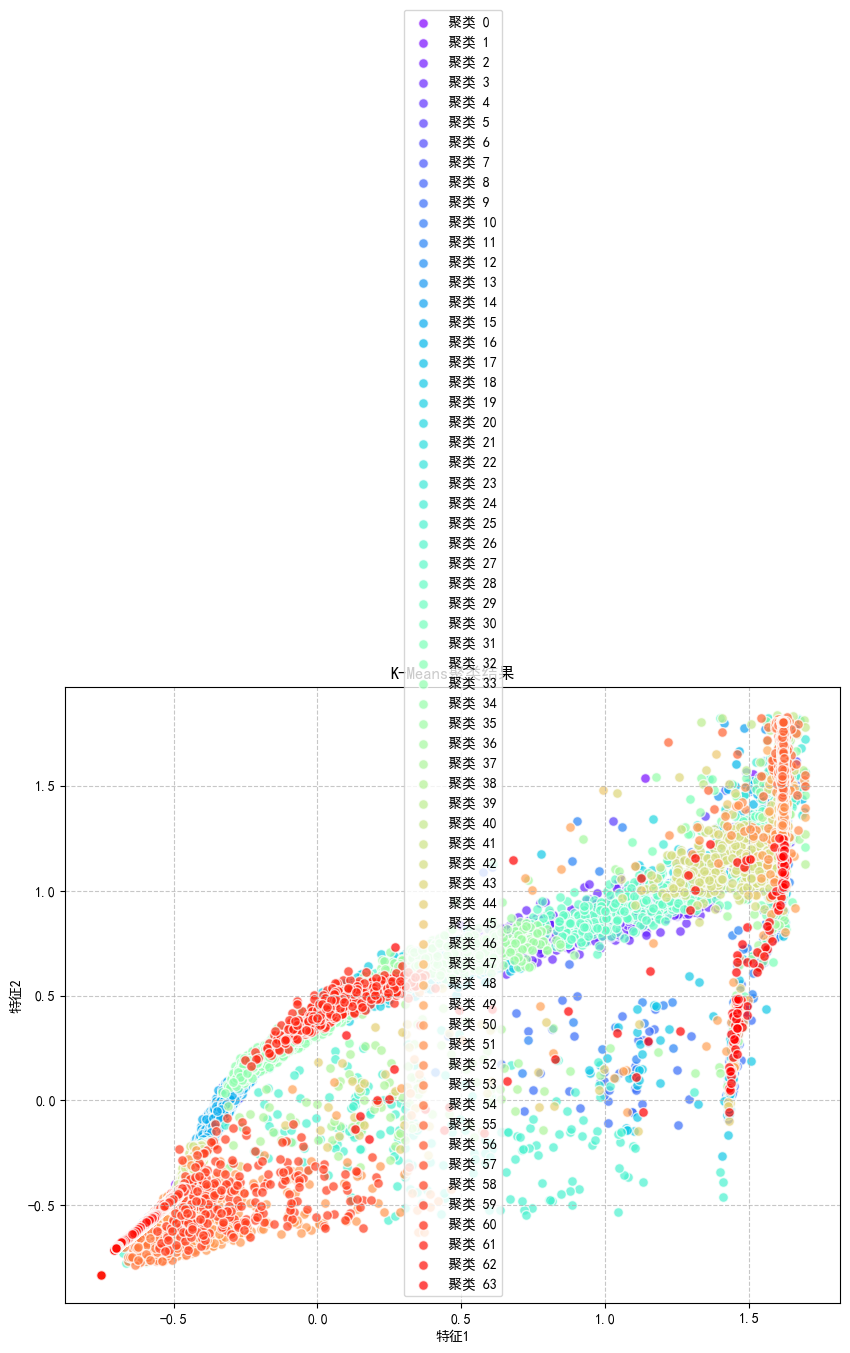

In [19]:
# 执行K-Means聚类
kmeans_labels = clustering.kmeans_clustering(n_clusters=len(all_class))

# 可视化K-Means结果
plt_kmeans = clustering.plot_clusters(title='K-Means聚类结果')
plt_kmeans.show()